In [37]:
import os
import cv2
import pandas as pd
import matplotlib.pyplot as plt
from tablepyxl import tablepyxl
from copy import deepcopy
import numpy as np
import io
from PIL import Image

In [1]:
from paddleocr import PPStructure,save_structure_res
from paddleocr.ppstructure.recovery.recovery_to_doc import sorted_layout_boxes, convert_info_docx

In [43]:
import fitz
doc = fitz.open('Sample\GCA RE.pdf')
page = doc[0]
pix = page.get_pixmap(dpi=300)
byte = io.BytesIO(pix.pil_tobytes(format="JPEG"))
image_pil = Image.open(byte)
img_arr = np.asarray(image_pil)

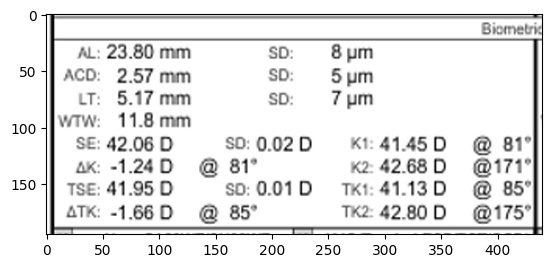

In [22]:
#read image table
path = 'Sample/IOL.png'
img = cv2.imread(path)
img = cv2.resize(img, (1000, 1500), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
img = img[600:795, 80:520]
plt.imshow(img)

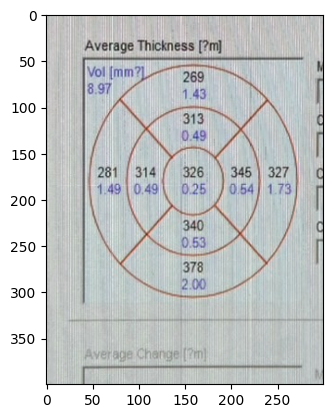

In [14]:
# read circle
path = 'Sample/S__33579013.jpg'
img = cv2.imread(path)
img = cv2.resize(img, (1600, 1100), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
img = img[400:800 , 750:1050]
plt.imshow(img)

In [13]:
# ocr circle
path = 'Sample/out.png'
img = cv2.imread(path)
# img = cv2.resize(img, (1600, 1100), fx=2, fy=2, interpolation=cv2.INTER_CUBIC)
img = img[1530:1850, 800:1200]
# plt.imshow(img)
img = Image.fromarray(img)

In [44]:
tmp = {
    "name1": [
        {
            "id": "circle_right",
            "type": "image",
            "box_pos": [800, 1530, 1200, 1850]  # x1, y1, x2, y2
        },
        {
            "id": "circle_left",
            "type": "image",
            "box_pos": [1500, 1530, 1900, 1850]
        }
    ],
    "name2": [
        {
            "id": "name",
            "type": "text",
            "box_pos": [127.440, 741.671, 204.817, 749.921]
        },
        {
            "id": "id",
            "type": "text",
            "box_pos": [127.440, 721.511, 164.136, 729.761]
        },
        {
            "id": "DOB",
            "type": "text",
            "box_pos": [127.440, 708.551, 164.119, 716.801]
        }
    ]
}

data_input = [{
        "template_name": tmp['name1'],
        "image": image_pil,
        "page": 1,
}]

In [46]:
# load model
def load_model():
    """
    load model from paddleocr (PPStructure)

    Returns:
        tabular engine model
    """
    table_engine = PPStructure(recovery=True, lang='en')
    return table_engine

def predict(table_engine, image):
    """
    predict table from image

    Args:
        table_engine: tabular engine model
        image: input image

    Returns:
        result of prediction
    """
    result = table_engine(image)
    return result

def process_result(result):
    """
    process result from prediction

    Args:
        result: result of prediction

    Returns:
        dataframe from result
    """
    result_cp = deepcopy(result)
    df_ls = []
    for region in result_cp:
        # if region is table
        if 'html' in region['res']:
            html = region['res']['html']
            wb = tablepyxl.document_to_workbook(html)
            output = io.BytesIO()
            wb.save(output)
            output.seek(0)
            df = pd.read_excel(output, header=None)
            df_ls.append(df)
        # else region is circle
        else:
            text_ls = []
            for text in region['res']:
                text_ls.append(text['text'])
            df = pd.DataFrame(text_ls)
            df_ls.append(df)
            
    return pd.concat(df_ls, axis=0) 

def inference(data_input, engine):
    """
    inference from input data

    Args:
        data_input (dict): input data
        engine : engine model

    Returns:
        dataframe from result    
    """
    df_predict_ls = []
    for page_index in range(len(data_input)):
        page = data_input[page_index]
        # image_path = page['path']
        # image = cv2.imread(image_path)
        image = page['image']
        image = np.asarray(image)
        for box_index in range(len(page['template_name'])):
            x1, y1, x2, y2 = page['template_name'][box_index]['box_pos']
            roi_image = image[y1:y2, x1:x2]
            result = predict(engine, roi_image)
            df_predict = process_result(result)
            columns_ls = [page['template_name'][box_index]['id']] * (len(df_predict.columns))
            df_predict.columns = columns_ls
            df_predict_ls.append(df_predict)
            
    return pd.concat(df_predict_ls, axis=1)


In [35]:
table_engine = load_model()

[2023/12/12 23:57:26] ppocr DEBUG: Namespace(alpha=1.0, alphacolor=(255, 255, 255), benchmark=False, beta=1.0, binarize=False, cls_batch_num=6, cls_image_shape='3, 48, 192', cls_model_dir=None, cls_thresh=0.9, cpu_threads=10, crop_res_save_dir='./output', det=True, det_algorithm='DB', det_box_type='quad', det_db_box_thresh=0.6, det_db_score_mode='fast', det_db_thresh=0.3, det_db_unclip_ratio=1.5, det_east_cover_thresh=0.1, det_east_nms_thresh=0.2, det_east_score_thresh=0.8, det_limit_side_len=960, det_limit_type='max', det_model_dir='C:\\Users\\earth/.paddleocr/whl\\det\\en\\en_PP-OCRv3_det_infer', det_pse_box_thresh=0.85, det_pse_min_area=16, det_pse_scale=1, det_pse_thresh=0, det_sast_nms_thresh=0.2, det_sast_score_thresh=0.5, draw_img_save_dir='./inference_results', drop_score=0.5, e2e_algorithm='PGNet', e2e_char_dict_path='./ppocr/utils/ic15_dict.txt', e2e_limit_side_len=768, e2e_limit_type='max', e2e_model_dir=None, e2e_pgnet_mode='fast', e2e_pgnet_score_thresh=0.5, e2e_pgnet_vali

In [47]:
inference(data_input, table_engine)

[2023/12/13 00:19:37] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.11687231063842773
[2023/12/13 00:19:38] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7560617923736572
[2023/12/13 00:19:39] ppocr DEBUG: dt_boxes num : 6, elapsed : 0.11554121971130371
[2023/12/13 00:19:39] ppocr DEBUG: rec_res num  : 6, elapsed : 0.7438163757324219


,circle_right,circle_left
0,89,108
1,86,101
2,88,87
3,65,75
4,81,62
5,71,58
